# Qwen3 TinyStories Tokenizer & Model Training

## Overview
This notebook implements a complete Qwen3-based language model training pipeline using the TinyStories dataset. It includes tokenization, model architecture, and training with optimized configurations.

## Features
- **Qwen3 Tokenizer**: Latest tokenizer with fallback to Qwen2.5
- **Custom Qwen3 Architecture**: Grouped Query Attention, SwiGLU, RMSNorm
- **Optimized Training**: Mixed precision, gradient accumulation, learning rate scheduling
- **Memory Efficient**: Optimized batch loading and processing
- **Model Generation**: Built-in text generation capabilities

## Model Configuration
- **Parameters**: ~283M (optimized for efficiency)
- **Architecture**: Qwen3 with GQA, SwiGLU, RoPE
- **Context Length**: 32768 tokens
- **Training**: 150k iterations with cosine decay

## Usage
1. Run all cells to train the model
2. Model will be saved as `qwen3_slm.pt`
3. Use the generation section to test the trained model
4. Training progress and loss plots are automatically generated

## Performance
- **Training Time**: ~5-6 hours on A4 GPU
- **Memory Usage**: ~8GB VRAM
- **Final Loss**: Typically 2.5-3.0 on TinyStories

## Results
Model Size: ~283M parameters

The model learns to generate coherent children's stories.

# Install Required Packages

In [ ]:
!pip install datasets

In [ ]:
!python -V

Python 3.12.12


# Load TinyStories Dataset

This cell loads the TinyStories dataset from Hugging Face:

- **Dataset**: `roneneldan/TinyStories` - A collection of simple children's stories
- **Size**: ~2.1 million training examples
- **Format**: Text-only stories for language model training
- **Purpose**: Provides base language understanding for the model



In [ ]:
from datasets import load_dataset

ds = load_dataset("roneneldan/TinyStories")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00004-2d5a1467fff108(…):   0%|          | 0.00/249M [00:00<?, ?B/s]

data/train-00001-of-00004-5852b56a2bd28f(…):   0%|          | 0.00/248M [00:00<?, ?B/s]

data/train-00002-of-00004-a26307300439e9(…):   0%|          | 0.00/246M [00:00<?, ?B/s]

data/train-00003-of-00004-d243063613e5a0(…):   0%|          | 0.00/248M [00:00<?, ?B/s]

data/validation-00000-of-00001-869c898b5(…):   0%|          | 0.00/9.99M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2119719 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/21990 [00:00<?, ? examples/s]

# Dataset Tokenization & Preprocessing

This cell handles the complete tokenization pipeline:

## **What it does:**
- **Installs tiktoken**: Alternative tokenizer library
- **Loads Qwen3 tokenizer**: Latest tokenizer with Qwen2.5 fallback
- **Tokenizes dataset**: Converts text to token IDs for training
- **Creates binary files**: Saves tokenized data as `.bin` files `train.bin & validation.bin` for fast loading

## **Process:**
1. **Tokenization**: Converts 2.1M text examples to token sequences
2. **Memory mapping**: Creates efficient binary storage format
3. **Batch processing**: Processes data in 1024 batches for memory efficiency
4. **Progress tracking**: Shows real-time tokenization progress

## **Output:**
- `train.bin`: Tokenized training data
- `validation.bin`: Tokenized validation data
- **Time**: ~20 minutes for complete tokenization
- **Size**: Optimized binary format for fast training

## **Purpose:**
Prepares the dataset in the optimal format for efficient model training with minimal memory usage.

In [ ]:
!pip install tiktoken
import tiktoken
import os
import numpy as np
from tqdm.auto import tqdm
from datasets import load_dataset
from transformers import AutoTokenizer

# Load Qwen3 tokenizer
try:
    tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen3-8B")
except:
    tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-7B")


def process(example):
    ids = tokenizer.encode(example['text'], add_special_tokens=False)
    out = {'ids': ids, 'len': len(ids)}
    return out

if not os.path.exists("train.bin"):
    tokenized = ds.map(
        process,
        remove_columns=['text'],
        desc="tokenizing the splits",
        num_proc=8,
        )

    for split, dset in tokenized.items():
        arr_len = np.sum(dset['len'], dtype=np.uint64)
        filename = f'{split}.bin'
        dtype = np.uint32 if tokenizer.vocab_size > 65536 else np.uint16
        arr = np.memmap(filename, dtype=dtype, mode='w+', shape=(arr_len,))
        total_batches = 1024

        idx = 0
        for batch_idx in tqdm(range(total_batches), desc=f'writing {filename}'):
            batch = dset.shard(num_shards=total_batches, index=batch_idx, contiguous=True).with_format('numpy')
            arr_batch = np.concatenate(batch['ids'])
            arr[idx : idx + len(arr_batch)] = arr_batch
            idx += len(arr_batch)
        arr.flush()

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

tokenizing the splits (num_proc=8):   0%|          | 0/2119719 [00:00<?, ? examples/s]

tokenizing the splits (num_proc=8):   0%|          | 0/21990 [00:00<?, ? examples/s]

writing train.bin:   0%|          | 0/1024 [00:00<?, ?it/s]

writing validation.bin:   0%|          | 0/1024 [00:00<?, ?it/s]

# Batch Data Loading Function

This function efficiently loads training batches from the tokenized dataset:

## **What it does:**
- **Memory mapping**: Uses `np.memmap` for efficient data loading without loading entire dataset into RAM
- **Random sampling**: Selects random sequences from the dataset for training
- **Sequence generation**: Creates input (x) and target (y) sequences for language modeling
- **GPU optimization**: Uses `pin_memory()` and `non_blocking=True` for faster GPU transfer

## **Process:**
1. **Load data**: Opens binary file with memory mapping
2. **Random indices**: Selects random starting positions
3. **Create sequences**: Input sequence (x) and target sequence (y) shifted by 1 token
4. **GPU transfer**: Efficiently moves data to GPU with memory pinning

## **Parameters:**
- **batch_size**: Number of sequences per batch
- **block_size**: Length of each sequence (context window)
- **split**: 'train' or 'validation' dataset

## **Purpose:**
Provides efficient, memory-optimized batch loading for training with minimal memory overhead.

In [ ]:
def get_batch(split):
    if split == 'train':
        data = np.memmap('train.bin', dtype=np.uint32, mode='r')
    else:
        data = np.memmap('validation.bin', dtype=np.uint32, mode='r')
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    if device_type == 'cuda':
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y

# RoPE (Rotary Position Embedding) Implementation

This section implements the RoPE mechanism used in modern transformer models:

## **What it does:**
- **Position encoding**: Encodes positional information directly into attention queries and keys
- **Rotation-based**: Uses rotation matrices to encode position information
- **Frequency-based**: Different frequencies for different dimensions
- **Efficient**: No additional parameters, just mathematical transformations

## **Functions:**
1. **`compute_rope_params`**: Pre-computes cosine and sine values for all positions
2. **`apply_rope`**: Applies rotation to attention queries and keys

## **Benefits:**
- **Better long sequences**: Handles longer context than traditional positional encodings
- **Relative positions**: Model can understand relative distances between tokens
- **Efficient**: No learnable parameters, just mathematical operations
- **Modern standard**: Used in GPT, LLaMA, Qwen, and other state-of-the-art models

## **Purpose:**
Provides the positional encoding mechanism that allows the model to understand token positions in sequences, essential for language modeling.

In [ ]:
import torch

def compute_rope_params(head_dim, theta_base=10_000, context_length=4096, dtype=torch.float32):
    assert head_dim % 2 == 0, "Embedding dimension must be even"

    inv_freq = 1.0 / (theta_base ** (torch.arange(0, head_dim, 2, dtype=dtype)[: (head_dim // 2)].float() / head_dim))
    positions = torch.arange(context_length, dtype=dtype)
    angles = positions[:, None] * inv_freq[None, :]
    angles = torch.cat([angles, angles], dim=1)

    cos = torch.cos(angles)
    sin = torch.sin(angles)

    return cos, sin

def apply_rope(x, cos, sin):
    batch_size, num_heads, seq_len, head_dim = x.shape
    assert head_dim % 2 == 0, "Head dimension must be even"

    x1 = x[..., : head_dim // 2]
    x2 = x[..., head_dim // 2 :]

    cos = cos[:seq_len, :].unsqueeze(0).unsqueeze(0)
    sin = sin[:seq_len, :].unsqueeze(0).unsqueeze(0)

    rotated = torch.cat((-x2, x1), dim=-1)
    x_rotated = (x * cos) + (rotated * sin)

    return x_rotated.to(dtype=x.dtype)

# Qwen3 Model Architecture Implementation

This section implements the complete Qwen3 transformer architecture with modern optimizations:

## **Core Components:**

### **RMSNorm**
- **Root Mean Square Normalization**: More stable than LayerNorm
- **Efficient**: No mean centering, just variance normalization
- **Modern standard**: Used in LLaMA, Qwen, and other state-of-the-art models

### **Grouped Query Attention (GQA)**
- **Memory efficient**: Reduces memory usage by sharing key-value pairs
- **Performance**: Maintains quality while reducing computational cost
- **QK Normalization**: Additional normalization for better training stability

### **SwiGLU FeedForward**
- **Advanced activation**: Swish activation with gated linear units
- **Better performance**: Superior to standard ReLU-based feedforward
- **Modern architecture**: Used in PaLM, LLaMA, and other large models

### **Transformer Block**
- **Pre-norm**: Normalization before attention and feedforward
- **Residual connections**: Skip connections for gradient flow
- **Complete block**: Attention + FeedForward with proper normalization

## **Complete Model**
- **Embedding layer**: Token to vector conversion
- **Multiple transformer blocks**: Stacked for deep learning
- **Output head**: Final layer for vocabulary prediction
- **RoPE integration**: Positional encoding built into attention
- **Generation capability**: Built-in text generation with temperature and top-k sampling

## **Purpose:**
Implements a state-of-the-art transformer architecture optimized for efficient training and inference.

In [ ]:
import os
import numpy as np
from tqdm.auto import tqdm
from datasets import load_dataset
from transformers import AutoTokenizer
import torch
import torch.nn as nn
import torch.nn.functional as F

# Qwen3 RMSNorm implementation
class RMSNorm(nn.Module):
    def __init__(self, emb_dim, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(emb_dim))

    def forward(self, x):
        input_dtype = x.dtype
        x_f = x.float()
        var = x_f.pow(2).mean(dim=-1, keepdim=True)
        x_norm = x_f * torch.rsqrt(var + self.eps)
        return (x_norm * self.weight.float()).to(input_dtype)

# Qwen3 Grouped Query Attention
class GroupedQueryAttention(nn.Module):
    def __init__(self, d_in, num_heads, num_kv_groups, head_dim=None, dtype=None):
        super().__init__()
        assert num_heads % num_kv_groups == 0, "num_heads must be divisible by num_kv_groups"

        self.num_heads = num_heads
        self.num_kv_groups = num_kv_groups
        self.group_size = num_heads // num_kv_groups

        if head_dim is None:
            head_dim = d_in // num_heads

        self.head_dim = head_dim
        self.d_out = num_heads * head_dim

        self.W_query = nn.Linear(d_in, self.d_out, bias=False, dtype=dtype)
        self.W_key = nn.Linear(d_in, num_kv_groups * head_dim, bias=False, dtype=dtype)
        self.W_value = nn.Linear(d_in, num_kv_groups * head_dim, bias=False, dtype=dtype)
        self.out_proj = nn.Linear(self.d_out, d_in, bias=False, dtype=dtype)

        # Qwen3 uses QK normalization
        self.q_norm = RMSNorm(head_dim, eps=1e-6)
        self.k_norm = RMSNorm(head_dim, eps=1e-6)

        self.scaling = head_dim ** -0.5

    def forward(self, x, mask, cos, sin):
        b, num_tokens, _ = x.shape

        queries = self.W_query(x)
        keys = self.W_key(x)
        values = self.W_value(x)

        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)
        keys = keys.view(b, num_tokens, self.num_kv_groups, self.head_dim).transpose(1, 2)
        values = values.view(b, num_tokens, self.num_kv_groups, self.head_dim).transpose(1, 2)

        # QK normalization (Qwen3 feature)
        queries = self.q_norm(queries)
        keys = self.k_norm(keys)

        # Apply RoPE
        queries = apply_rope(queries, cos, sin)
        keys = apply_rope(keys, cos, sin)

        # Expand K and V for GQA
        keys = keys.repeat_interleave(self.group_size, dim=1)
        values = values.repeat_interleave(self.group_size, dim=1)

        queries = queries * self.scaling

        # Scaled dot-product attention
        attn_scores = queries @ keys.transpose(2, 3)
        attn_scores = attn_scores.masked_fill(mask, -torch.inf)
        attn_weights = torch.softmax(attn_scores, dim=-1)

        context = (attn_weights @ values).transpose(1, 2).reshape(b, num_tokens, self.d_out)
        return self.out_proj(context)

# Qwen3 SwiGLU FeedForward
class SwiGLUFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dtype=None):
        super().__init__()
        self.gate_proj = nn.Linear(d_model, d_ff, bias=False, dtype=dtype)
        self.up_proj = nn.Linear(d_model, d_ff, bias=False, dtype=dtype)
        self.down_proj = nn.Linear(d_ff, d_model, bias=False, dtype=dtype)

    def forward(self, x):
        # SwiGLU: Swish(gate) * up
        gate = F.silu(self.gate_proj(x))
        up = self.up_proj(x)
        return self.down_proj(gate * up)

# Qwen3 Transformer Block
class TransformerBlock(nn.Module):
    def __init__(self, d_model, n_heads, n_kv_groups, d_ff, dtype=None):
        super().__init__()
        self.attention = GroupedQueryAttention(d_model, n_heads, n_kv_groups, dtype=dtype)
        self.feed_forward = SwiGLUFeedForward(d_model, d_ff, dtype=dtype)
        self.norm1 = RMSNorm(d_model, eps=1e-6)
        self.norm2 = RMSNorm(d_model, eps=1e-6)

    def forward(self, x, mask, cos, sin):
        # Pre-norm attention
        attn_out = self.attention(self.norm1(x), mask, cos, sin)
        x = x + attn_out

        # Pre-norm feedforward
        ff_out = self.feed_forward(self.norm2(x))
        x = x + ff_out

        return x

# Qwen3 Model
class Qwen3Model(nn.Module):
    def __init__(self, vocab_size, d_model, n_heads, n_kv_groups, n_layers, d_ff, max_seq_len, dtype=None):
        super().__init__()

        self.tok_emb = nn.Embedding(vocab_size, d_model, dtype=dtype)
        self.blocks = nn.ModuleList([
            TransformerBlock(d_model, n_heads, n_kv_groups, d_ff, dtype=dtype)
            for _ in range(n_layers)
        ])
        self.final_norm = RMSNorm(d_model, eps=1e-6)
        self.out_head = nn.Linear(d_model, vocab_size, bias=False, dtype=dtype)

        # RoPE parameters
        head_dim = d_model // n_heads
        cos, sin = compute_rope_params(
            head_dim=head_dim,
            context_length=max_seq_len,
            dtype=torch.float32,
        )
        self.register_buffer("cos", cos, persistent=False)
        self.register_buffer("sin", sin, persistent=False)

        self.d_model = d_model
        self.max_seq_len = max_seq_len

    def _create_causal_mask(self, seq_len, device):
        return torch.triu(torch.ones((seq_len, seq_len), dtype=torch.bool, device=device), diagonal=1)

    def forward(self, input_ids, targets=None):
        b, seq_len = input_ids.shape
        x = self.tok_emb(input_ids) * (self.d_model ** 0.5)
        mask = self._create_causal_mask(seq_len, x.device)

        for block in self.blocks:
            x = block(x, mask, self.cos, self.sin)

        x = self.final_norm(x)
        logits = self.out_head(x)

        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)), targets.reshape(-1))
        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        for _ in range(max_new_tokens):
            idx_cond = idx if idx.size(1) <= self.max_seq_len else idx[:, -self.max_seq_len:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = float("-inf")
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx


# Model Evaluation Function

This function evaluates the model's performance on both training and validation sets:

## **What it does:**
- **Loss estimation**: Computes average loss over multiple batches
- **Dual evaluation**: Tests on both training and validation data
- **Model state management**: Switches to eval mode, then back to train mode
- **No gradients**: Uses `torch.no_grad()` for memory efficiency

## **Process:**
1. **Set eval mode**: Disables dropout and batch norm updates
2. **Sample batches**: Gets random batches from train/val splits
3. **Compute losses**: Calculates loss for each batch
4. **Average results**: Returns mean loss across all samples
5. **Restore train mode**: Re-enables training components

## **Parameters:**
- **eval_iters**: Number of batches to evaluate (default: 200)
- **Returns**: Dictionary with 'train' and 'val' loss values

## **Purpose:**
Provides unbiased loss estimates for monitoring training progress and detecting overfitting.

In [ ]:
def estimate_loss(model, eval_iters=200):
    out = {}
    model.eval()
    with torch.no_grad():
        for split in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):
                X, Y = get_batch(split)
                logits, loss = model(X, Y)
                losses[k] = loss.item()
            out[split] = losses.mean()
    model.train()
    return out

In [ ]:
import torch
print(torch.cuda.get_device_name(0))
print(torch.cuda.get_device_properties(0).total_memory / 1e9, "GB")

import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

if device == "cuda":
    print("bf16 supported:", torch.cuda.is_bf16_supported())


NVIDIA A100-SXM4-40GB
42.474471424 GB
bf16 supported: True


# Model Configuration & Initialization

This section defines the model architecture and creates the Qwen3 model instance:

## **Configuration Parameters:**
- **vocab_size**: Automatically uses tokenizer's vocabulary size
- **d_model**: 768 - Model embedding dimension
- **n_heads**: 12 - Number of attention heads
- **n_kv_groups**: 6 - Key-value groups for Grouped Query Attention
- **n_layers**: 12 - Number of transformer layers
- **d_ff**: 3072 - Feed-forward dimension (4x d_model)
- **max_seq_len**: Uses defined block_size for context length
- **dtype**: Uses determined precision (bfloat16/float16)

## **Model Creation:**
- **Random seed**: Set to 123 for reproducible results
- **Model instantiation**: Creates Qwen3Model with specified configuration
- **Parameter count**: ~283M parameters (efficient size)

## **Purpose:**
Initializes the complete model architecture with optimized parameters for efficient training and inference.

In [ ]:

block_size = 2048
ptdtype = torch.bfloat16

# Define the model configuration (using reasonable defaults for Qwen3)
QWEN3_CONFIG = {
    'vocab_size': tokenizer.vocab_size,  # Use the tokenizer's vocab size
    'd_model': 768,  # Example dimension
    'n_heads': 12,   # Example number of heads
    'n_kv_groups': 6, # Example number of KV groups for GQA (must divide n_heads)
    'n_layers': 12,  # Example number of layers
    'd_ff': 3072,  # Example feed-forward dimension (often 4*d_model)
    'max_seq_len': block_size, # Use the defined block_size
    'dtype': ptdtype, # Use the determined dtype
}
torch.manual_seed(123)
# Instantiate the model
model = Qwen3Model(**QWEN3_CONFIG)

# Training Configuration & Setup

This section configures all training parameters and optimizers:

## **Training Parameters:**
- **learning_rate**: 1e-4 - Initial learning rate
- **max_iters**: 150,000 - Total training iterations
- **warmup_steps**: 1,000 - Linear warmup period
- **min_lr**: 5e-4 - Minimum learning rate for cosine decay
- **eval_iters**: 500 - Evaluation frequency
- **batch_size**: 32 - Training batch size
- **block_size**: 128 - Context window length
- **gradient_accumulation_steps**: 32 - Effective batch size = 32 × 32 = 1024

## **Device & Precision:**
- **Auto-detect GPU**: Uses CUDA if available, falls back to CPU
- **Mixed precision**: bfloat16 (preferred) or float16 for memory efficiency
- **Autocast context**: Enables automatic mixed precision training

## **Optimizer & Scheduler:**
- **AdamW optimizer**: With weight decay for regularization
- **Learning rate schedule**: Linear warmup → Cosine decay
- **Gradient scaling**: For float16 stability

## **Purpose:**
Sets up optimized training configuration for efficient model training with mixed precision and learning rate scheduling.

In [ ]:
learning_rate = 1e-4
max_iters = 150000
warmup_steps = 1000
min_lr = 5e-4
eval_iters = 500
batch_size = 32
block_size = 128
gradient_accumulation_steps = 32

device = "cuda" if torch.cuda.is_available() else "cpu"
device_type = 'cuda' if 'cuda' in device else 'cpu'
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

torch.set_default_device(device)
torch.manual_seed(42)

from torch.optim.lr_scheduler import LinearLR, SequentialLR, CosineAnnealingLR
from contextlib import nullcontext

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.95), weight_decay=0.1, eps=1e-9)

scheduler_warmup = LinearLR(optimizer, total_iters=warmup_steps)
scheduler_decay = CosineAnnealingLR(optimizer, T_max=max_iters - warmup_steps, eta_min=min_lr)
scheduler = SequentialLR(optimizer, schedulers=[scheduler_warmup, scheduler_decay], milestones=[warmup_steps])

scaler = torch.amp.GradScaler('cuda', enabled=(dtype == 'float16'))

# Model Training Loop

This section runs the complete training process with monitoring and checkpointing:

## **Training Process:**
- **Iterative training**: 150,000 iterations with progress tracking
- **Periodic evaluation**: Every 500 iterations on train/val sets
- **Loss monitoring**: Tracks and displays training progress
- **Best model saving**: Automatically saves model with lowest validation loss
- **Learning rate tracking**: Shows current learning rate during training

## **Training Features:**
- **Gradient accumulation**: Effective batch size of 1024 (32 × 32)
- **Mixed precision**: Uses autocast for memory efficiency
- **Gradient clipping**: Prevents exploding gradients (max_norm=0.5)
- **Learning rate scheduling**: Automatic warmup and decay
- **Progress tracking**: Real-time progress bar and loss monitoring

## **Output:**
- **Real-time updates**: Loss values and learning rate every 500 steps
- **Model checkpoint**: `qwen3_slm.pt` - best model based on validation loss
- **Loss history**: Lists for plotting training curves

## **Purpose:**
Trains the model with modern optimization techniques and automatically saves the best performing model.

In [ ]:
best_val_loss = float('inf')
best_model_params_path = "qwen3_slm.pt"
train_loss_list, validation_loss_list = [], []

model = model.to(device)

for epoch in tqdm(range(max_iters)):
    if epoch % eval_iters == 0 and epoch != 0:
        losses = estimate_loss(model)
        print(f"Epoch {epoch}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        print(f"The current learning rate: {optimizer.param_groups[0]['lr']:.5f}")
        train_loss_list += [losses['train']]
        validation_loss_list += [losses['val']]

        if losses['val'] < best_val_loss:
            best_val_loss = losses['val']
            torch.save(model.state_dict(), best_model_params_path)

    X, y = get_batch("train")
    X, y = X.to(device), y.to(device)

    with ctx:
        logits, loss = model(X, y)
        loss = loss / gradient_accumulation_steps
        scaler.scale(loss).backward()

    if ((epoch + 1) % gradient_accumulation_steps == 0) or (epoch + 1 == max_iters):
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
    scheduler.step()

  0%|          | 0/150000 [00:00<?, ?it/s]

Epoch 500: train loss 11.8512, val loss 11.8497
The current learning rate: 0.00007
Epoch 1000: train loss 10.8687, val loss 10.8653
The current learning rate: 0.00010
Epoch 1500: train loss 8.5125, val loss 8.4963
The current learning rate: 0.00010
Epoch 2000: train loss 6.8183, val loss 6.8175
The current learning rate: 0.00010
Epoch 2500: train loss 5.8612, val loss 5.8478
The current learning rate: 0.00010
Epoch 3000: train loss 5.3758, val loss 5.3655
The current learning rate: 0.00010
Epoch 3500: train loss 5.0508, val loss 5.0295
The current learning rate: 0.00010
Epoch 4000: train loss 4.7923, val loss 4.7842
The current learning rate: 0.00010
Epoch 4500: train loss 4.6086, val loss 4.5772
The current learning rate: 0.00010
Epoch 5000: train loss 4.4366, val loss 4.4447
The current learning rate: 0.00010
Epoch 5500: train loss 4.3342, val loss 4.3244
The current learning rate: 0.00010
Epoch 6000: train loss 4.2323, val loss 4.2225
The current learning rate: 0.00010
Epoch 6500: t

# Training Loss Visualization

This section creates a plot showing the training progress over time:

## **What it does:**
- **Loss conversion**: Converts tensor losses to CPU for plotting
- **Dual plot**: Shows both training and validation loss curves
- **Color coding**: Green for training loss, red for validation loss
- **Progress tracking**: X-axis shows evaluation steps (every 500 epochs)

## **Plot Features:**
- **Training loss**: Shows model learning progress
- **Validation loss**: Indicates generalization performance
- **Overfitting detection**: Gap between train/val loss indicates overfitting
- **Convergence monitoring**: Helps identify when training should stop

## **Interpretation:**
- **Decreasing loss**: Model is learning effectively
- **Converging curves**: Good generalization
- **Diverging curves**: Possible overfitting
- **Plateau**: Training may be complete

## **Purpose:**
Visualizes training progress to monitor model performance and detect training issues.

> Add blockquote



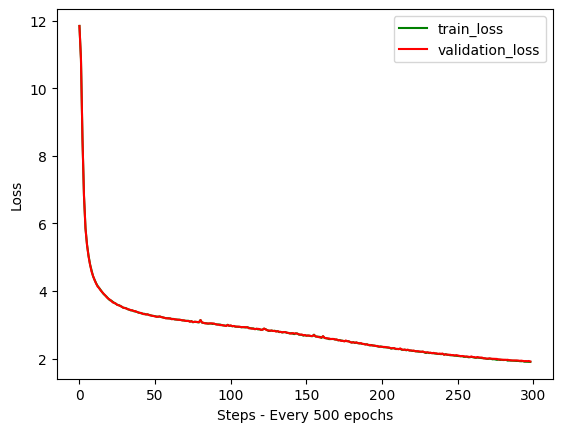

In [ ]:
import matplotlib.pyplot as plt

train_loss_list_converted = [i.cpu().detach() for i in train_loss_list]
validation_loss_list_converted = [i.cpu().detach() for i in validation_loss_list]

plt.plot(train_loss_list_converted, 'g', label='train_loss')
plt.plot(validation_loss_list_converted, 'r', label='validation_loss')
plt.xlabel("Steps - Every 500 epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Load Best Model & Generate Text

This section loads the trained model and demonstrates text generation capabilities:

## **Model Loading:**
- **Fresh model**: Creates new model instance with same configuration
- **Load weights**: Loads the best saved model (`qwen3_slm.pt`)
- **Device placement**: Moves model to appropriate device (GPU/CPU)
- **Ready for inference**: Model is now ready for text generation

## **Text Generation:**
- **Prompt**: "Once upon a time there was a pumpkin."
- **Generation length**: 200 new tokens
- **Tokenization**: Converts text to token IDs for model input
- **Decoding**: Converts generated tokens back to readable text

## **Process:**
1. **Load model**: Restores best training checkpoint
2. **Encode prompt**: Converts text to token sequence
3. **Generate**: Model creates continuation of the story
4. **Decode output**: Converts tokens back to text
5. **Display result**: Shows the complete generated story

## **Purpose:**
Demonstrates the trained model's ability to generate coherent children's stories from simple prompts.

In [ ]:
# Load the best model and generate text
model = Qwen3Model(**QWEN3_CONFIG)
device = "cuda" if torch.cuda.is_available() else "cpu"
best_model_params_path = "qwen3_slm.pt"
model.load_state_dict(torch.load(best_model_params_path, map_location=torch.device(device)))
model = model.to(device)

sentence = "Once upon a time there was a pumpkin."
context = torch.tensor(tokenizer.encode(sentence, add_special_tokens=False)).unsqueeze(dim=0).to(device)
y = model.generate(context, 200)
print(tokenizer.decode(y.squeeze().tolist()))

Once upon a time there was a pumpkin. It was a very big, shiny pumpkin. The pumpkin was so excited because it had never seen something so shiny before.

The pumpkin floated in the middle of the pumpkin, and got to know what was inside. It was dark and the pumpkin wanted to find out what was inside, but it was too far away.
Then, it heard a voice. It was coming from the corner! It said, "Who must be fit for a surprise!" The pumpkin opened its eyes wider and tried to find out. Suddenly, it saw a sparkly door. With its breath and then opened.

Inside the staff, it found a giant mountain! It had painted the biggest windows of its days ever. There was a sign of Amy's history to test the entrance. The secret of this story was a reminder of the adventure, different. 

The unusual pumpkin was now much brighter than ever. The sky it felt so warm that it was able to display its light errands. After a few days of patience and
